In [5]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
#from wordcloud import WordCloud ,STOPWORDS
#from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import re
from spell import *

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
# Read data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [9]:
# count each severity 
print('non toxic: %d' % train[(train['insult'] == 0) & (train['toxic'] == 0) & 
                        (train['obscene'] == 0) & (train['threat'] == 0) &
                        (train['identity_hate'] == 0) & (train['severe_toxic'] == 0)]['id'].count())
print('toxic: %d' % train[train['toxic'] > 0]['toxic'].count())
print('severe_toxic: %d' % train[train['severe_toxic'] > 0]['severe_toxic'].count())
print('obscene: %d' % train[train['obscene'] > 0]['obscene'].count())
print('threat: %d' % train[train['threat'] > 0]['threat'].count())
print('insult: %d' % train[train['insult'] > 0]['insult'].count())
print('identity_hate: %d' % train[train['identity_hate'] > 0]['identity_hate'].count())

non toxic: 143346
toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405


In [6]:
print('Severe toxic but NOT toxic?: %d' % train[(train['severe_toxic'] > 0) & (train['toxic'] == 0)]['id'].count())
print('Insult but NOT toxic?: %d' % train[(train['insult'] > 0) & (train['toxic'] == 0)]['id'].count())
print('Obscene but NOT toxic?: %d' % train[(train['obscene'] > 0) & (train['toxic'] == 0)]['id'].count())
print('Threat but NOT insult?: %d' % train[(train['threat'] > 0) & (train['insult'] == 0)]['id'].count())

Severe toxic but NOT toxic?: 0
Insult but NOT toxic?: 533
Obscene but NOT toxic?: 523
Threat but NOT insult?: 171


#### Some observations
1. Most frequent labels are toxic, obscene and insult. They seem to be the major categories.
2. Toxic and severe_toxic label are related while all other labels seem to be independent

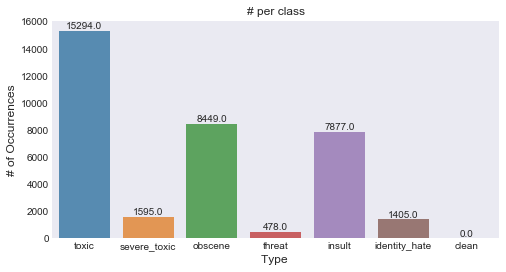

In [16]:
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)

x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

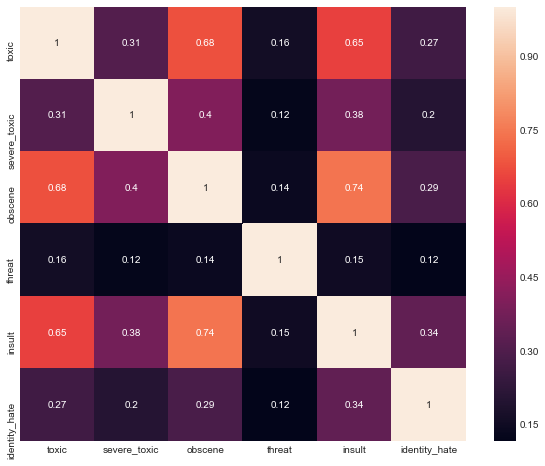

In [17]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

### other features
* Proportion of capitals
* Number of unique words
* Number of exclamation marks
* Number of punctuations

In [18]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)

In [19]:
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))

In [20]:
train['num_punctuation'] = train['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '.,;:'))

In [21]:
train['num_unique_words'] = train['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))

In [22]:
train['num_:'] = train['comment_text'].apply(lambda comment: comment.count(':'))

### To do
1. create own bad words dictionary by collecting bad word from training datase

In [46]:
import string
puncs = string.punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
pattern = r"[{}]".format(puncs) # create the pattern
#if re.match("[\.|\?|\\|\,|\*|\!|\~|\;|\-|\(|\[|\{|\@|\#|\$|\%|\^|\&|\)|\_|\=|\/|\|\:|\"|\'|\<|\>]", word):
word = re.sub(pattern, ' ', word)
word = correction(word.lower())

[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]
fuck


In [79]:
word = '(((fck'
if re.match("(\w*)(\.|\?|\\|\,|\*|\!|\~|\;|\-|\(|\[|\{|\@|\#|\$|\%|\^|\&|\)|\_|\=|\/|\|\:|\"|\'|\<|\>)(\w*)", word):
    print("match")

match


In [5]:
def find_words(text): return re.findall(r'\w+', text.lower())

In [25]:
toxic_dict

{'cocksucker': 553,
 'piss': 179,
 'around': 351,
 'work': 546,
 'hey': 622,
 'talk': 1233,
 'exclusive': 9,
 'group': 117,
 'wp': 248,
 'taliban': 4,
 'good': 768,
 'destroying': 18,
 'self': 256,
 'purist': 1,
 'gang': 31,
 'one': 1573,
 'asks': 9,
 'question': 225,
 'abt': 1,
 'anti': 227,
 'destructive': 10,
 'ask': 179,
 'sityush': 2,
 'clean': 52,
 'behavior': 95,
 'issue': 154,
 'nonsensical': 6,
 'warning': 406,
 'bye': 71,
 'look': 634,
 'come': 736,
 'think': 1322,
 'comming': 2,
 'back': 699,
 'tosser': 17,
 'gay': 2243,
 'antisemmitian': 1,
 'archangel': 1,
 'white': 219,
 'tiger': 8,
 'meow': 2,
 'greetingshhh': 1,
 'uh': 24,
 'two': 291,
 'way': 727,
 'erased': 13,
 'comment': 616,
 'holocaust': 24,
 'brutally': 5,
 'slaying': 2,
 'jew': 1554,
 'shave': 7,
 'head': 285,
 'bald': 45,
 'go': 2954,
 'skinhead': 5,
 'meeting': 19,
 'doubt': 61,
 'word': 432,
 'bible': 34,
 'homosexuality': 32,
 'deadly': 6,
 'sin': 15,
 'make': 1173,
 'pentagram': 2,
 'tatoo': 2,
 'forehead':

In [76]:
for comments in train,test:
    # remove '\\n'
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub('\\n',' ',str(x)))
    
    # remove any text starting with User... 
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
    
    # remove IP addresses or user IDs
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    
    # lower uppercase letters
    comments['comment_text'] = comments['comment_text'].map(lambda x: str(x).lower())
    
    #remove http links in the text
    comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)|(www..*)",'',str(x)))
    
    #remove all punctuation except for apostrophe (')
    #comments['comment_text'] = comments['comment_text'].map(lambda x: re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','',str(x)))

In [78]:
train['comment_text'].head

<bound method NDFrame.head of 0         explanation why the edits made under my userna...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         " more i can't make any real suggestions on im...
4         you, sir, are my hero. any chance you remember...
5         "  congratulations from me as well, use the to...
6              cocksucker before you piss around on my work
7         your vandalism to the matt shirvington article...
8         sorry if the word 'nonsense' was offensive to ...
9         alignment on this subject and which are contra...
10        " fair use rationale for image:wonju.jpg  than...
11        bbq   be a man and lets discuss it-maybe over ...
12        hey... what is it.. @ | talk . what is it... a...
13        before you start throwing accusations and warn...
14        oh, and the girl above started her arguments w...
15        "  juelz santanas age  in 2002, juelz santana ...
16        

In [92]:
re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', '', 'word,')

AttributeError: module 're' has no attribute 'complier'

In [95]:
from tqdm import tqdm 
with open("data/pronous_list.txt", "r") as f:
    pronous = f.read()

pronouslist = pronous.lower().split(", ")

def get_cleanData(data):
    word_freq_dict = {}
    total_words = 0
    total_clean_words = 0
    
    for sentence in tqdm(data):
        #words = find_words(str(sentence))
        word_sen = str(sentence).strip().lower().split()
        #toxic_words = tokenizer.tokenize(str(sentence).lower())
        total_words += len(word_sen)
        for word in word_sen:
            if word not in eng_stopwords and word not in pronouslist:
                if re.match("(\w*)(\.|\?|\\|\,|\*|\!|\~|\;|\-|\(|\[|\{|\@|\#|\$|\%|\^|\&|\)|\_|\=|\/|\|\:|\"|\'|\<|\>|\`)(\w*)", word):
                    word = re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', '', word)
                    if word not in WORDS:
                        word = correction(word)
                if word not in eng_stopwords and word not in pronouslist:
                    total_clean_words += 1
                    word = re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', '', word)
                    word = lem.lemmatize(word)
                    if word not in word_freq_dict:
                        word_freq_dict[word] = 0
                    word_freq_dict[word] += 1
    print("total words:", total_words)
    print("total clean words:", total_clean_words)
    print("total distinct clean words:", len(word_freq_dict))
    return word_freq_dict

import os, csv
def store_file(word_freq_dict, filename):
    w_f ="\n".join([str(k)+' '+" " + str(v) for k,v in word_freq_dict.items()]) 
    with open(os.path.join('data',filename), 'w', encoding='utf-8') as f:  # Just use 'w' mode in 3.x
        f.write(w_f)

In [96]:
severe_toxic_data = train[train['severe_toxic'] > 0]['comment_text']
severe_toxic_word_freq_dict = get_cleanData(severe_toxic_data)
store_file(severe_toxic_word_freq_dict, "severe_toxic_clean_data.csv")

 70%|██████████████████████████████████████████████████████▍                       | 1113/1595 [27:26<11:52,  1.48s/it]

KeyboardInterrupt: 

In [ ]:
obscene_data = train[train['obscene'] > 0]['comment_text']
obscene_word_freq_dict = get_cleanData(obscene_data)
store_file(obscene_word_freq_dict, "obscene_clean_data.csv")


  0%|▏                                                                               | 16/8449 [00:05<47:15,  2.97it/s]
Exception in thread Thread-9:
Traceback (most recent call last):
  File "E:\software\anaconda\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "E:\software\anaconda\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "E:\software\anaconda\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 20%|███████████████▏                                                            | 1683/8449 [15:48<1:03:31,  1.78it/s]

In [ ]:
threat_data = train[train['threat'] > 0]['comment_text']
threat_word_freq_dict = get_cleanData(threat_data)
store_file(threat_word_freq_dict, "threat_clean_data.csv")

In [ ]:
insult_data = train[train['insult'] > 0]['comment_text']
insult_word_freq_dict = get_cleanData(insult_data)
store_file(insult_word_freq_dict, "insult_clean_data.csv")

In [ ]:
identity_hate_data = train[train['identity_hate'] > 0]['comment_text']
identity_hate_word_freq_dict = get_cleanData(identity_hate_data)
store_file(identity_hate_word_freq_dict, "identity_hate_clean_data.csv")

In [ ]:
toxic_data = train[train['toxic'] > 0]['comment_text']
toxic_word_freq_dict = get_cleanData(toxic_data)
store_file(toxic_word_freq_dict, "toxic_clean_data.csv")